# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    num_workers=0
    transform = transforms.Compose([transforms.Resize((image_size,image_size)), # resize to 128x128
                                    transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(data_dir, transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

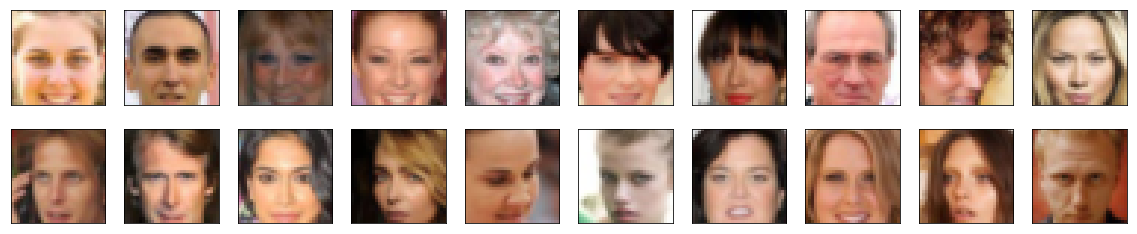

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min,max = feature_range
    x = x * (max-min)+min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8039)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim=conv_dim
        # complete init function
        self.conv1=conv(3,conv_dim,4,batch_norm=False)
        self.conv2=conv(conv_dim,conv_dim*2,4)
        self.conv3=conv(conv_dim*2,conv_dim*4,4)
        
        self.fc1=nn.Linear(4*4*conv_dim*4,1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.conv2(x),0.2)
        x = F.leaky_relu(self.conv3(x),0.2)
        x = x.view(-1,4*4*self.conv_dim*4)
        x = self.fc1(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim=conv_dim
        # complete init function
        self.fc1 = nn.Linear(z_size,conv_dim*4*4*4)
        self.dconv1=deconv(conv_dim*4,conv_dim*2,4)
        self.dconv2=deconv(conv_dim*2,conv_dim,4)
        self.dconv3=deconv(conv_dim,3,4,batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        x = x.view(-1,self.conv_dim*4,4,4)
        x = F.relu(self.dconv1(x))
        x = F.relu(self.dconv2(x))
        x = F.tanh(self.dconv3(x))
        
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (dconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dconv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size=D_out.size(0)
    labels=torch.ones(batch_size)*0.9
    if train_on_gpu:
        labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size=D_out.size(0)
    labels=torch.zeros(batch_size)*0.9
    if train_on_gpu:
        labels = labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels) 
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim
lr = 0.0002
beta1=0.5
beta2=0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr,[beta1, beta2])
g_optimizer = optim.Adam(G.parameters(),lr,[beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            if train_on_gpu:
                real_images = real_images.cuda()
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            out_d_r=D(real_images)
            r_loss = real_loss(out_d_r)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            out_d_f=D(fake_images)
            f_loss=fake_loss(out_d_f)
            
            d_loss = r_loss+f_loss
            d_loss.backward()
            d_optimizer.step()
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            out = D(fake_images)
            g_loss = real_loss(out)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.5397 | g_loss: 1.3902
Epoch [    1/   30] | d_loss: 0.3819 | g_loss: 4.4984
Epoch [    1/   30] | d_loss: 0.6346 | g_loss: 5.1242
Epoch [    1/   30] | d_loss: 0.8408 | g_loss: 4.4006
Epoch [    1/   30] | d_loss: 1.0586 | g_loss: 2.7165
Epoch [    1/   30] | d_loss: 0.9618 | g_loss: 3.5139
Epoch [    1/   30] | d_loss: 1.5169 | g_loss: 1.3381
Epoch [    1/   30] | d_loss: 0.9750 | g_loss: 1.4564
Epoch [    1/   30] | d_loss: 0.9058 | g_loss: 2.4016
Epoch [    1/   30] | d_loss: 0.8189 | g_loss: 1.7935
Epoch [    1/   30] | d_loss: 1.1494 | g_loss: 1.1105
Epoch [    1/   30] | d_loss: 0.9736 | g_loss: 1.9926
Epoch [    1/   30] | d_loss: 1.0844 | g_loss: 1.7817
Epoch [    1/   30] | d_loss: 1.1926 | g_loss: 1.1615
Epoch [    1/   30] | d_loss: 0.9615 | g_loss: 1.3611
Epoch [    1/   30] | d_loss: 1.1444 | g_loss: 1.6009
Epoch [    1/   30] | d_loss: 1.2584 | g_loss: 1.2949
Epoch [    1/   30] | d_loss: 1.1241 | g_loss: 1.8795
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.9391 | g_loss: 1.8711
Epoch [    3/   30] | d_loss: 1.1568 | g_loss: 0.8520
Epoch [    3/   30] | d_loss: 0.9579 | g_loss: 2.0465
Epoch [    3/   30] | d_loss: 1.2356 | g_loss: 1.3755
Epoch [    3/   30] | d_loss: 1.0652 | g_loss: 1.4818
Epoch [    3/   30] | d_loss: 1.0397 | g_loss: 1.2762
Epoch [    3/   30] | d_loss: 1.2254 | g_loss: 1.4435
Epoch [    3/   30] | d_loss: 1.3175 | g_loss: 1.3920
Epoch [    3/   30] | d_loss: 1.0397 | g_loss: 1.6473
Epoch [    3/   30] | d_loss: 1.1496 | g_loss: 1.3063
Epoch [    3/   30] | d_loss: 1.2266 | g_loss: 0.8731
Epoch [    3/   30] | d_loss: 1.2609 | g_loss: 1.5864
Epoch [    3/   30] | d_loss: 1.1049 | g_loss: 1.0160
Epoch [    3/   30] | d_loss: 0.8743 | g_loss: 1.3930
Epoch [    3/   30] | d_loss: 1.1669 | g_loss: 1.2143
Epoch [    3/   30] | d_loss: 0.8394 | g_loss: 1.0784
Epoch [    3/   30] | d_loss: 0.7647 | g_loss: 1.0714
Epoch [    3/   30] | d_loss: 0.9121 | g_loss: 1.2124
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 1.2018 | g_loss: 1.7736
Epoch [    6/   30] | d_loss: 1.0719 | g_loss: 1.9529
Epoch [    6/   30] | d_loss: 1.2010 | g_loss: 1.4120
Epoch [    6/   30] | d_loss: 0.8863 | g_loss: 1.3738
Epoch [    6/   30] | d_loss: 1.0719 | g_loss: 0.8467
Epoch [    6/   30] | d_loss: 0.8770 | g_loss: 1.3333
Epoch [    6/   30] | d_loss: 0.8379 | g_loss: 1.5630
Epoch [    6/   30] | d_loss: 0.7416 | g_loss: 2.4108
Epoch [    6/   30] | d_loss: 0.9971 | g_loss: 1.5642
Epoch [    6/   30] | d_loss: 0.8380 | g_loss: 2.3029
Epoch [    6/   30] | d_loss: 1.0420 | g_loss: 1.3465
Epoch [    6/   30] | d_loss: 0.9221 | g_loss: 1.8738
Epoch [    6/   30] | d_loss: 0.9003 | g_loss: 1.7618
Epoch [    6/   30] | d_loss: 0.9590 | g_loss: 1.8342
Epoch [    6/   30] | d_loss: 0.8293 | g_loss: 1.3991
Epoch [    6/   30] | d_loss: 0.6537 | g_loss: 1.9011
Epoch [    6/   30] | d_loss: 0.7880 | g_loss: 1.4959
Epoch [    6/   30] | d_loss: 0.9975 | g_loss: 1.4786
Epoch [    6/   30] | d_loss

Epoch [    9/   30] | d_loss: 1.4302 | g_loss: 2.3960
Epoch [    9/   30] | d_loss: 0.6777 | g_loss: 2.0379
Epoch [    9/   30] | d_loss: 0.8215 | g_loss: 2.5563
Epoch [    9/   30] | d_loss: 0.8110 | g_loss: 2.2413
Epoch [    9/   30] | d_loss: 0.8444 | g_loss: 1.8379
Epoch [    9/   30] | d_loss: 0.7616 | g_loss: 2.1275
Epoch [    9/   30] | d_loss: 0.6700 | g_loss: 2.2851
Epoch [    9/   30] | d_loss: 0.9335 | g_loss: 2.1292
Epoch [    9/   30] | d_loss: 0.9303 | g_loss: 1.2506
Epoch [    9/   30] | d_loss: 0.6041 | g_loss: 2.4031
Epoch [    9/   30] | d_loss: 0.8601 | g_loss: 1.0836
Epoch [    9/   30] | d_loss: 0.7747 | g_loss: 4.7087
Epoch [    9/   30] | d_loss: 1.1894 | g_loss: 2.1642
Epoch [    9/   30] | d_loss: 1.0051 | g_loss: 0.9083
Epoch [    9/   30] | d_loss: 0.9062 | g_loss: 1.4663
Epoch [    9/   30] | d_loss: 0.6106 | g_loss: 2.9946
Epoch [    9/   30] | d_loss: 0.5514 | g_loss: 1.7434
Epoch [    9/   30] | d_loss: 0.7100 | g_loss: 2.6948
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.5363 | g_loss: 3.3499
Epoch [   11/   30] | d_loss: 0.7184 | g_loss: 2.2408
Epoch [   11/   30] | d_loss: 0.5692 | g_loss: 2.6563
Epoch [   11/   30] | d_loss: 0.8248 | g_loss: 3.0719
Epoch [   11/   30] | d_loss: 0.6675 | g_loss: 2.8460
Epoch [   11/   30] | d_loss: 0.7703 | g_loss: 1.2396
Epoch [   11/   30] | d_loss: 0.6575 | g_loss: 1.0366
Epoch [   11/   30] | d_loss: 0.7164 | g_loss: 3.0092
Epoch [   11/   30] | d_loss: 0.6383 | g_loss: 2.1282
Epoch [   11/   30] | d_loss: 0.5359 | g_loss: 2.7144
Epoch [   11/   30] | d_loss: 0.5953 | g_loss: 2.8444
Epoch [   11/   30] | d_loss: 0.5277 | g_loss: 1.8626
Epoch [   11/   30] | d_loss: 0.8753 | g_loss: 2.3196
Epoch [   11/   30] | d_loss: 0.6394 | g_loss: 1.4511
Epoch [   11/   30] | d_loss: 0.6889 | g_loss: 2.9372
Epoch [   11/   30] | d_loss: 0.5368 | g_loss: 2.2050
Epoch [   11/   30] | d_loss: 0.6254 | g_loss: 2.7019
Epoch [   11/   30] | d_loss: 0.6382 | g_loss: 2.0414
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.5475 | g_loss: 2.3102
Epoch [   14/   30] | d_loss: 0.4936 | g_loss: 3.1017
Epoch [   14/   30] | d_loss: 0.5172 | g_loss: 3.0489
Epoch [   14/   30] | d_loss: 0.5873 | g_loss: 2.5701
Epoch [   14/   30] | d_loss: 0.5429 | g_loss: 2.8661
Epoch [   14/   30] | d_loss: 0.4549 | g_loss: 2.8043
Epoch [   14/   30] | d_loss: 0.6520 | g_loss: 2.9192
Epoch [   14/   30] | d_loss: 0.5146 | g_loss: 3.1908
Epoch [   14/   30] | d_loss: 0.4841 | g_loss: 2.6900
Epoch [   14/   30] | d_loss: 0.7791 | g_loss: 3.5941
Epoch [   14/   30] | d_loss: 0.6574 | g_loss: 2.0579
Epoch [   14/   30] | d_loss: 0.6289 | g_loss: 1.7862
Epoch [   14/   30] | d_loss: 0.4802 | g_loss: 2.5994
Epoch [   14/   30] | d_loss: 0.8452 | g_loss: 2.2812
Epoch [   14/   30] | d_loss: 0.4710 | g_loss: 3.7479
Epoch [   14/   30] | d_loss: 0.4609 | g_loss: 2.4434
Epoch [   14/   30] | d_loss: 0.4245 | g_loss: 3.0254
Epoch [   14/   30] | d_loss: 0.7190 | g_loss: 3.2368
Epoch [   14/   30] | d_loss

Epoch [   17/   30] | d_loss: 0.4464 | g_loss: 3.1295
Epoch [   17/   30] | d_loss: 0.4328 | g_loss: 2.7972
Epoch [   17/   30] | d_loss: 0.4778 | g_loss: 2.8451
Epoch [   17/   30] | d_loss: 0.6382 | g_loss: 2.8526
Epoch [   17/   30] | d_loss: 0.8382 | g_loss: 2.6153
Epoch [   17/   30] | d_loss: 0.4402 | g_loss: 3.3186
Epoch [   17/   30] | d_loss: 0.5833 | g_loss: 2.1430
Epoch [   17/   30] | d_loss: 0.4571 | g_loss: 3.4416
Epoch [   17/   30] | d_loss: 0.6242 | g_loss: 2.9705
Epoch [   17/   30] | d_loss: 0.6128 | g_loss: 3.1017
Epoch [   17/   30] | d_loss: 0.7602 | g_loss: 2.0950
Epoch [   17/   30] | d_loss: 0.6730 | g_loss: 3.0647
Epoch [   17/   30] | d_loss: 0.9169 | g_loss: 1.0873
Epoch [   17/   30] | d_loss: 0.8428 | g_loss: 1.6130
Epoch [   17/   30] | d_loss: 0.5414 | g_loss: 2.1208
Epoch [   17/   30] | d_loss: 0.4831 | g_loss: 3.0376
Epoch [   17/   30] | d_loss: 0.6589 | g_loss: 4.1832
Epoch [   17/   30] | d_loss: 0.5644 | g_loss: 2.6881
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.4474 | g_loss: 3.7251
Epoch [   19/   30] | d_loss: 0.4571 | g_loss: 2.1760
Epoch [   19/   30] | d_loss: 0.9181 | g_loss: 2.8617
Epoch [   19/   30] | d_loss: 0.5602 | g_loss: 3.1342
Epoch [   19/   30] | d_loss: 0.6427 | g_loss: 2.6612
Epoch [   19/   30] | d_loss: 0.4981 | g_loss: 3.5193
Epoch [   19/   30] | d_loss: 0.9375 | g_loss: 1.5140
Epoch [   19/   30] | d_loss: 0.5968 | g_loss: 3.8390
Epoch [   19/   30] | d_loss: 0.5045 | g_loss: 2.5651
Epoch [   19/   30] | d_loss: 0.4832 | g_loss: 2.6911
Epoch [   19/   30] | d_loss: 0.4670 | g_loss: 3.4828
Epoch [   19/   30] | d_loss: 0.4298 | g_loss: 3.6413
Epoch [   19/   30] | d_loss: 0.7574 | g_loss: 2.6518
Epoch [   19/   30] | d_loss: 0.4659 | g_loss: 2.7388
Epoch [   19/   30] | d_loss: 0.5198 | g_loss: 4.3072
Epoch [   19/   30] | d_loss: 0.5386 | g_loss: 3.4189
Epoch [   19/   30] | d_loss: 0.4601 | g_loss: 3.9567
Epoch [   19/   30] | d_loss: 0.5035 | g_loss: 3.0479
Epoch [   19/   30] | d_loss

Epoch [   22/   30] | d_loss: 0.4336 | g_loss: 2.6879
Epoch [   22/   30] | d_loss: 0.4216 | g_loss: 2.1734
Epoch [   22/   30] | d_loss: 0.7321 | g_loss: 4.0911
Epoch [   22/   30] | d_loss: 0.6650 | g_loss: 2.5557
Epoch [   22/   30] | d_loss: 0.4337 | g_loss: 3.2839
Epoch [   22/   30] | d_loss: 1.6485 | g_loss: 5.3768
Epoch [   22/   30] | d_loss: 0.5693 | g_loss: 2.7205
Epoch [   22/   30] | d_loss: 0.3908 | g_loss: 4.7984
Epoch [   22/   30] | d_loss: 0.4007 | g_loss: 3.2380
Epoch [   22/   30] | d_loss: 1.0087 | g_loss: 1.2645
Epoch [   22/   30] | d_loss: 0.4499 | g_loss: 4.1584
Epoch [   22/   30] | d_loss: 0.4190 | g_loss: 3.5486
Epoch [   22/   30] | d_loss: 0.3890 | g_loss: 3.2351
Epoch [   22/   30] | d_loss: 0.5084 | g_loss: 3.1171
Epoch [   22/   30] | d_loss: 0.4713 | g_loss: 3.1792
Epoch [   22/   30] | d_loss: 0.4907 | g_loss: 3.2955
Epoch [   22/   30] | d_loss: 0.4030 | g_loss: 3.7100
Epoch [   22/   30] | d_loss: 0.5337 | g_loss: 2.4418
Epoch [   22/   30] | d_loss

Epoch [   25/   30] | d_loss: 0.6382 | g_loss: 2.7615
Epoch [   25/   30] | d_loss: 0.4311 | g_loss: 4.1805
Epoch [   25/   30] | d_loss: 0.4935 | g_loss: 2.5485
Epoch [   25/   30] | d_loss: 0.5249 | g_loss: 2.4255
Epoch [   25/   30] | d_loss: 0.3806 | g_loss: 4.0493
Epoch [   25/   30] | d_loss: 0.4513 | g_loss: 3.4672
Epoch [   25/   30] | d_loss: 0.5765 | g_loss: 2.9003
Epoch [   25/   30] | d_loss: 0.3795 | g_loss: 4.9638
Epoch [   25/   30] | d_loss: 0.4577 | g_loss: 2.3546
Epoch [   25/   30] | d_loss: 0.4765 | g_loss: 3.5777
Epoch [   25/   30] | d_loss: 2.4263 | g_loss: 0.4823
Epoch [   25/   30] | d_loss: 0.6290 | g_loss: 2.3820
Epoch [   25/   30] | d_loss: 0.6495 | g_loss: 2.4354
Epoch [   25/   30] | d_loss: 0.4654 | g_loss: 2.9176
Epoch [   25/   30] | d_loss: 0.4841 | g_loss: 2.8216
Epoch [   25/   30] | d_loss: 0.5286 | g_loss: 2.4808
Epoch [   25/   30] | d_loss: 0.5507 | g_loss: 2.6971
Epoch [   25/   30] | d_loss: 0.7437 | g_loss: 2.0524
Epoch [   25/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.6784 | g_loss: 2.4001
Epoch [   27/   30] | d_loss: 0.4887 | g_loss: 3.4146
Epoch [   27/   30] | d_loss: 0.4802 | g_loss: 2.9716
Epoch [   27/   30] | d_loss: 0.4238 | g_loss: 2.1970
Epoch [   27/   30] | d_loss: 0.4042 | g_loss: 3.4683
Epoch [   27/   30] | d_loss: 0.4041 | g_loss: 4.5468
Epoch [   27/   30] | d_loss: 0.4333 | g_loss: 3.6103
Epoch [   27/   30] | d_loss: 0.5017 | g_loss: 2.4099
Epoch [   27/   30] | d_loss: 0.4862 | g_loss: 2.3170
Epoch [   27/   30] | d_loss: 0.5071 | g_loss: 1.5298
Epoch [   27/   30] | d_loss: 0.4810 | g_loss: 4.7337
Epoch [   27/   30] | d_loss: 0.5399 | g_loss: 2.5487
Epoch [   27/   30] | d_loss: 0.5165 | g_loss: 4.0157
Epoch [   27/   30] | d_loss: 0.4536 | g_loss: 2.9617
Epoch [   27/   30] | d_loss: 0.4493 | g_loss: 3.9327
Epoch [   27/   30] | d_loss: 0.4177 | g_loss: 3.3707
Epoch [   27/   30] | d_loss: 0.5912 | g_loss: 3.0795
Epoch [   27/   30] | d_loss: 0.4892 | g_loss: 2.9344
Epoch [   27/   30] | d_loss

Epoch [   30/   30] | d_loss: 0.3665 | g_loss: 5.2868
Epoch [   30/   30] | d_loss: 0.5484 | g_loss: 2.5898
Epoch [   30/   30] | d_loss: 0.5887 | g_loss: 3.0193
Epoch [   30/   30] | d_loss: 0.4161 | g_loss: 4.5438
Epoch [   30/   30] | d_loss: 0.4647 | g_loss: 4.3839
Epoch [   30/   30] | d_loss: 0.4526 | g_loss: 3.7254
Epoch [   30/   30] | d_loss: 0.4577 | g_loss: 3.3644
Epoch [   30/   30] | d_loss: 0.3965 | g_loss: 5.1857
Epoch [   30/   30] | d_loss: 0.4630 | g_loss: 3.2274
Epoch [   30/   30] | d_loss: 0.7183 | g_loss: 3.9630
Epoch [   30/   30] | d_loss: 0.5101 | g_loss: 2.8165
Epoch [   30/   30] | d_loss: 0.5496 | g_loss: 3.6078
Epoch [   30/   30] | d_loss: 0.4195 | g_loss: 4.1670
Epoch [   30/   30] | d_loss: 0.4696 | g_loss: 2.7169
Epoch [   30/   30] | d_loss: 0.4530 | g_loss: 4.2499
Epoch [   30/   30] | d_loss: 0.4860 | g_loss: 2.9693
Epoch [   30/   30] | d_loss: 0.4860 | g_loss: 2.3252
Epoch [   30/   30] | d_loss: 0.4259 | g_loss: 3.5146
Epoch [   30/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

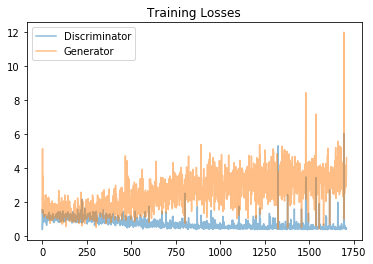

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

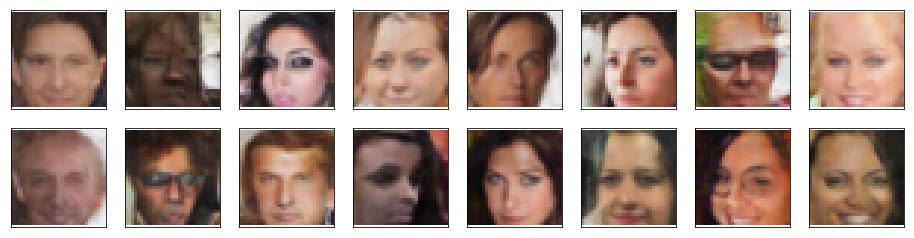

In [26]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
- Taking in consideration the mentioned factors, I have noticed that none of the faces I generated have dark skin. One possible solution is to balance the number of examples per etnicity.
- Pictures are low resolution, to make it better a larger model would be needed as well as higher resolution inputs.
- I first trained the network for 10 epochs then for 30 epochs and it produced good results but still had some artifacts, for example some faces had half the glasses (or blended with the face) and some others had two different hair styles. 
- Loss looks like it is overshooting I could try lowering the learning rate so it won't spike that much.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.